In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd drive
# %cd 'My Drive'
# %cd 'IS projects'
# %cd CL
# %cd DataSets

[Errno 2] No such file or directory: 'drive'
/content/drive/My Drive/IS projects/CL/DataSets
[Errno 2] No such file or directory: 'My Drive'
/content/drive/My Drive/IS projects/CL/DataSets
[Errno 2] No such file or directory: 'IS projects'
/content/drive/My Drive/IS projects/CL/DataSets
[Errno 2] No such file or directory: 'CL'
/content/drive/My Drive/IS projects/CL/DataSets
[Errno 2] No such file or directory: 'DataSets'
/content/drive/My Drive/IS projects/CL/DataSets


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import sklearn.cluster
import sklearn.metrics
from sklearn.metrics import pairwise_distances
import matplotlib.cm as cm
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture


newcmp = ListedColormap(['#B79FE7', '#cebeef','#3D1E5B', '#C1ADD6',  '#A384C1', '#845BAD', '#3D1E5B', '#e6def7', '#4d279b'])


In [14]:
read_data =  lambda filename :  pd.read_csv(filename).to_numpy()

In [15]:
toy_data_set = read_data('ToyDataSet.csv')

### Saving Metric Indicators for all Algorithms in two lists

In [8]:
def seperation_index(data, cluster_indices, p = 2):

    def intra_distance(cluster, p = 2): #Calculates maximum intra-cluster distance

        if(p ==2):
            return np.amax(pairwise_distances(cluster, metric = "euclidean"))

        else:
            pairwise = np.zeros((len(cluster), len(cluster)))
            for i in range(len(cluster)):
                for j in range(len(cluster)):
                    pairwise[i][j] = np.linalg.norm(cluster[i] - cluster[j], p)
            print(pairwise)
        return np.amax(pairwise)

    def inter_distance(cluster1, cluster2, p = 2):  #Calculates minimum inter-cluster distance (single-link)
        x = np.zeros((len(cluster1), len(cluster2)))
        x = [[np.linalg.norm(cluster1[i]-cluster2[j], p) for i in range(len(cluster1)) ] for j in range(len(cluster2))]
        return np.amin(x)
    
        
    num_clusters = len(np.unique(cluster_indices))
    cluster_mapping = {} # Dictinary; Partitioning data based on cluster indices

    for i in range(num_clusters):
        cluster_mapping[np.unique(cluster_indices)[i]] = data[np.where(cluster_indices == i)]


    temp = []
    if(num_clusters == 1):
        return 0
    
    for j in range(num_clusters):
        
        inner_temp = []
        for i in range(num_clusters):
            if(i!=j):# Iterating over other clusters after fixing one cluster
                
                # Higher Seperation for Algorithm with further clusters:
                num = inter_distance(data[np.where(cluster_indices ==i)], data[np.where(cluster_indices ==j)], p) 
               
                # Higher Seperation for Algorithm with denser clusters 
                den = np.amax([intra_distance(data[np.where(cluster_indices ==l)], p)  for l in range(num_clusters)]) #
                
                # Normalizing numerators across the whole cluster pairs with the denumerator 
                inner_temp.append(num/den) 
                
    temp.append(min(inner_temp)) 

    seperation_index = min(temp) # Assuming a pessimistic lowerbound along the seperation metric for all pairs

    return seperation_index
        

In [9]:
def fisher_index(data, cluster_indices):
    num_clusters = len(np.unique(cluster_indices))
    data_dimension = len(data[0])
    
    epsilon = (np.amax(data)-np.amin(data))/(10**5) # Preventing Singularity of Sw
    clusters = {} # Dictinary; Partitioning data based on cluster indices

    for i in range(num_clusters):
        clusters[np.unique(cluster_indices)[i]] = data[np.where(cluster_indices == i)]

    if(num_clusters==1):
        return 0
    
    centroids = []
    
    Sw = np.zeros((data_dimension, data_dimension))
    for i in range(len(clusters)):
        Si = np.zeros((data_dimension, data_dimension))
        for q in range(len(clusters[i])):
            
            # Calculating Variance Matrix to obtain Si & Sw
            mul = np.matmul(np.transpose(np.array([clusters[i][q] - np.mean(clusters[i][q])])), np.array([clusters[i][q] - np.mean(clusters[i][q])]))
            Si = np.add(Si, mul)
            
        centroids.append(np.mean(clusters[i], axis = 0)) # Calculating Clusters Centroids
    Sw = np.add(Sw, Si)
    
    
    total_centroid  = np.mean(centroids, axis = 0) # Calculating Between Cluster Covariability using Centroids Covariance Matrix
    Sb = np.zeros((data_dimension, data_dimension))
    
    for i in range(num_clusters):
        Sb = np.add(Sb, np.matmul(np.transpose(np.array([(centroids[i] - (total_centroid))])), np.array([(centroids[i] - (total_centroid))])))
    
    Sw = np.add(Sw, epsilon*np.eye(data_dimension))
    FDI = np.trace(np.matmul(np.linalg.inv(Sw), Sb)) 
    return FDI


In [112]:
def barchart_comparison(algorithms, seperations, fdis, clr = '#ccbfde', title = None): #Gets list of Algorithm Names and Corresponding Seo, Fisher Metrics

    fig, ax = plt.subplots(1, 2, figsize = (20, 7))
    fig.tight_layout(pad = 10.0)

    y_pos = np.arange(len(algorithms))
    ax[0].barh(algorithms, seperations, color = clr)
    ax[0].set_xlabel('Seperation Indices')

    ax[1].barh(algorithms, fdis, color = clr)
    ax[1].set_xlabel('FDI')

    plt.show()

In [11]:
sep_ind = []
fda_ind = []

In [5]:
def elbow_method(data, inertias, end_range):
  k_candidates = range(1, end_range)
  for k in k_candidates:
      k_means = sklearn.cluster.KMeans(random_state=0, n_clusters=k).fit(data)
      inertias.append(k_means.inertia_)

In [6]:
def silhouette_score_method(algorithm, data, silhouette_avgs, end_range, flag, *argv):
  k_candidates = range(2, end_range)
  for k in k_candidates:
    if flag == 0 :
      clusterer = algorithm(n_clusters = k).fit(data)

    elif flag == 1 :
      clusterer = algorithm(n_clusters = k, linkage = argv[0]).fit(data)

    cluster_labels = clusterer.labels_
    silhouette_avg = sklearn.metrics.silhouette_score(data, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

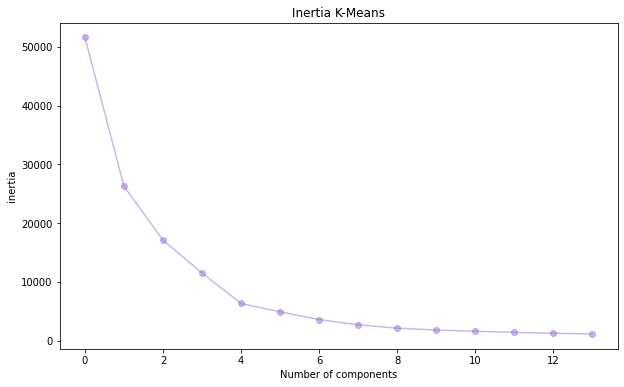

In [ ]:
inertias = []
elbow_method(toy_data_set, inertias, end_range = 15)
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(len(inertias)), inertias, '-o', alpha = 0.5, color = 'mediumpurple')
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='Number of components');

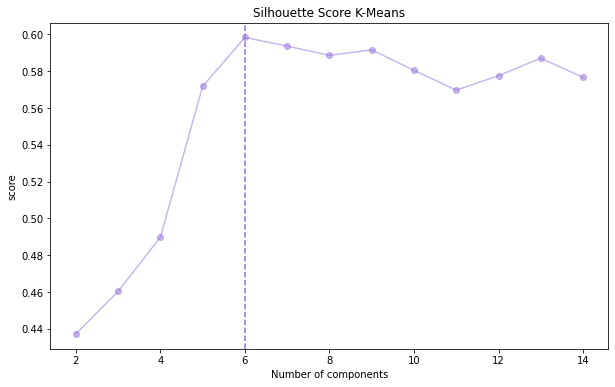

In [ ]:
km_silhouette_avgs = []
silhouette_score_method(sklearn.cluster.KMeans, toy_data_set, km_silhouette_avgs, end_range = 15, flag = 0)
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2, len(km_silhouette_avgs)+2), km_silhouette_avgs, '-o', alpha = 0.5, color = 'mediumpurple')
ax.set(title='Silhouette Score K-Means', ylabel = 'score', xlabel='Number of components');
ax.axvline(x = np.argmax(km_silhouette_avgs) + 2, color = 'mediumpurple', label = 'zero eigenvalues', linestyle  ='--')
plt.show()

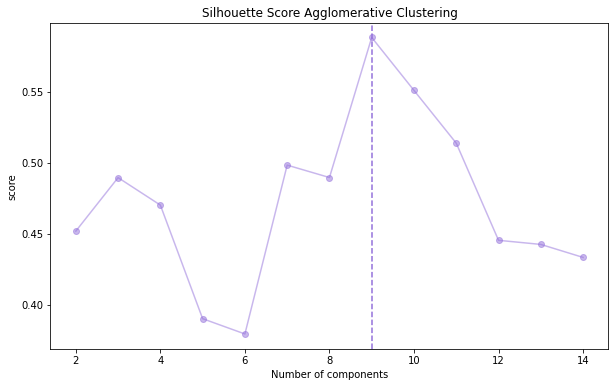

In [ ]:
agg_silhouette_avgs = []
silhouette_score_method(sklearn.cluster.AgglomerativeClustering, toy_data_set, agg_silhouette_avgs, 15,  1, 'single')
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2, len(agg_silhouette_avgs)+2), agg_silhouette_avgs, '-o', alpha = 0.5, color = 'mediumpurple')
ax.set(title='Silhouette Score Agglomerative Clustering', ylabel = 'score', xlabel= 'Number of components');
ax.axvline(x = np.argmax(agg_silhouette_avgs) + 2, color = 'mediumpurple', label = 'zero eigenvalues', linestyle  ='--')
plt.show()

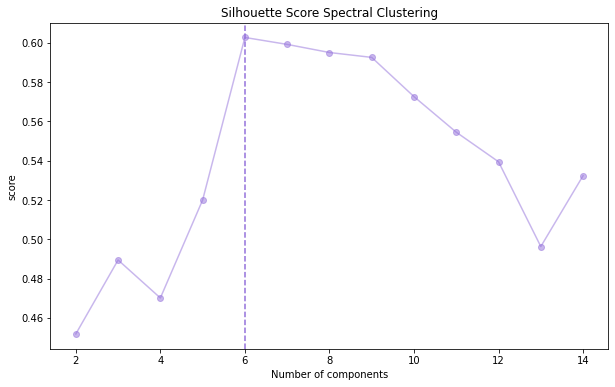

In [ ]:
spec_silhouette_avgs = []
silhouette_score_method(sklearn.cluster.SpectralClustering, toy_data_set, spec_silhouette_avgs, end_range =  15, flag =  0)
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2, len(spec_silhouette_avgs)+2), spec_silhouette_avgs, '-o', alpha = 0.5, color = 'mediumpurple')
ax.set(title='Silhouette Score Spectral Clustering', ylabel = 'score', xlabel='Number of components');
ax.axvline(x = np.argmax(spec_silhouette_avgs) + 2, color = 'mediumpurple', linestyle  ='--')
plt.show()

In [ ]:
peaks = 2
range_n_km_clusters =  [idx + 2 for idx in sorted(range(len(km_silhouette_avgs)), key = lambda sub: km_silhouette_avgs[sub])[-peaks:]]
range_n_agg_clusters =  [idx + 2 for idx in sorted(range(len(agg_silhouette_avgs)), key = lambda sub: agg_silhouette_avgs[sub])[-peaks:]]
range_n_spec_clusters =  [idx + 2 for idx in sorted(range(len(spec_silhouette_avgs)), key = lambda sub: spec_silhouette_avgs[sub])[-peaks:]]

In [ ]:
range_n_km_clusters[::-1]

[6, 7]

In [ ]:
range_n_agg_clusters[::-1]

[9, 10]

In [ ]:
range_n_spec_clusters[::-1]

[6, 7]

In [ ]:
def algorithm_parameters(algorithm, data, n_clusters, flag = 0, *argv):
  if flag == 0 :
    clusterer = algorithm(n_clusters = n_clusters).fit(data)

  elif flag == 1 :
    clusterer = algorithm(n_clusters = k, linkage = argv[0]).fit(data)
  cluster_labels = clusterer.labels_
  silhouette_avg = sklearn.metrics.silhouette_score(data, cluster_labels)
  sample_silhouette_values = sklearn.metrics.silhouette_samples(data, cluster_labels)
  cluster_centers = [np.mean(data[cluster_labels == i], axis = 0) for i in range(np.unique(cluster_labels).shape[0])]
  return sample_silhouette_values, silhouette_avg, cluster_labels, cluster_centers

In [ ]:
def silhouette_plot_method(range_clusters, algorithm, data, alg):
  for n_clusters in range_clusters:

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])
    sample_silhouette_values, silhouette_avg, cluster_labels, centers = algorithm_parameters(algorithm, data, n_clusters)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.Purples(float(i) / n_clusters + 0.3)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor = color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    ax1.set(title = "The silhouette plot for the various clusters.", xlabel = "The silhouette coefficient values", ylabel = "Cluster label")
    ax1.axvline(x = silhouette_avg, color="silver", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.2 , 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.Purples(cluster_labels.astype(float) / n_clusters + 0.3 )
    ax2.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker='.', s=30, lw=0, alpha=0.7, c = colors, edgecolor='k')
    for i, c in enumerate(centers): ax2.scatter(c[0], c[1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers): ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
    ax2.set(title = "The visualization of the clustered data.", xlabel = "Feature space for the 1st feature", ylabel = "Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for " + alg + " clustering on sample data with %d clusters " % n_clusters), fontsize = 14, fontweight='bold')

plt.show()

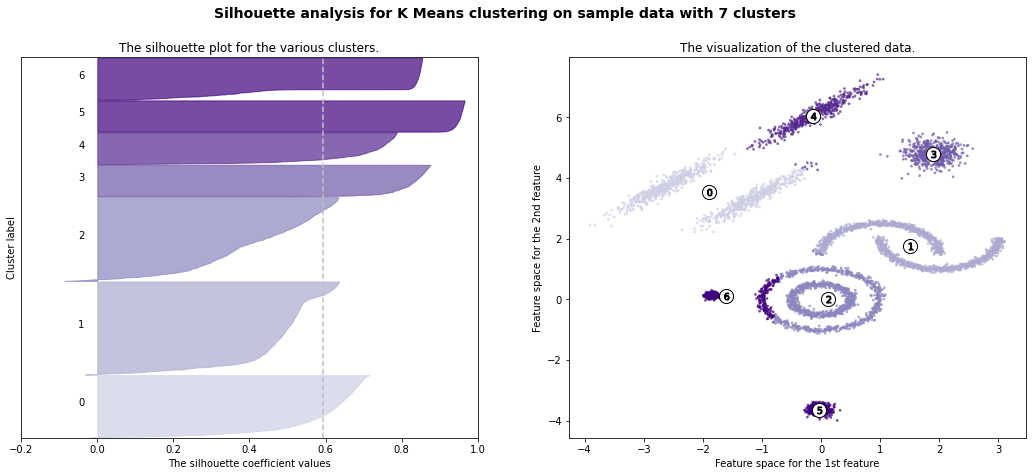

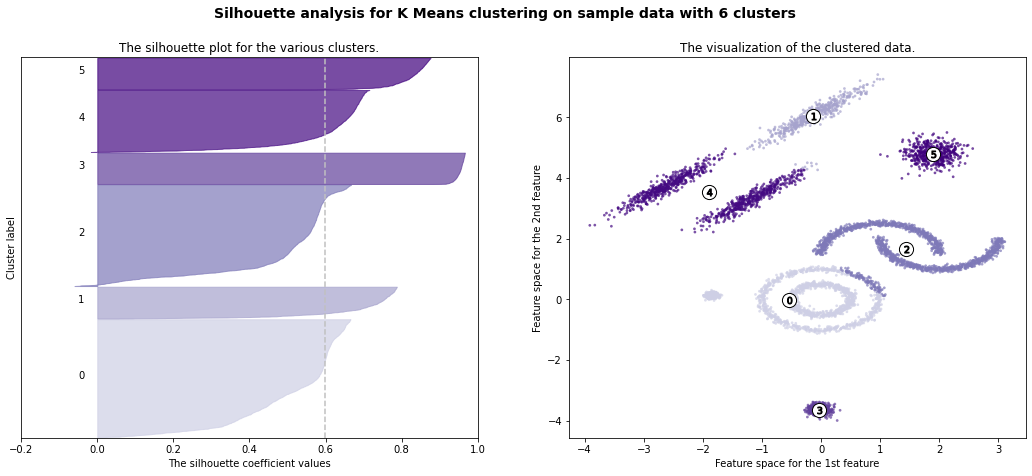

In [ ]:
algorithm = [sklearn.cluster.KMeans, sklearn.cluster.AgglomerativeClustering, sklearn.cluster.SpectralClustering]
alg = ['K Means', 'Agglomerative Clustering', 'Spectral Clustering']  
range_clusters = [range_n_km_clusters, range_n_agg_clusters, range_n_spec_clusters]
silhouette_plot_method(range_clusters[0], algorithm[0], toy_data_set, alg[0])

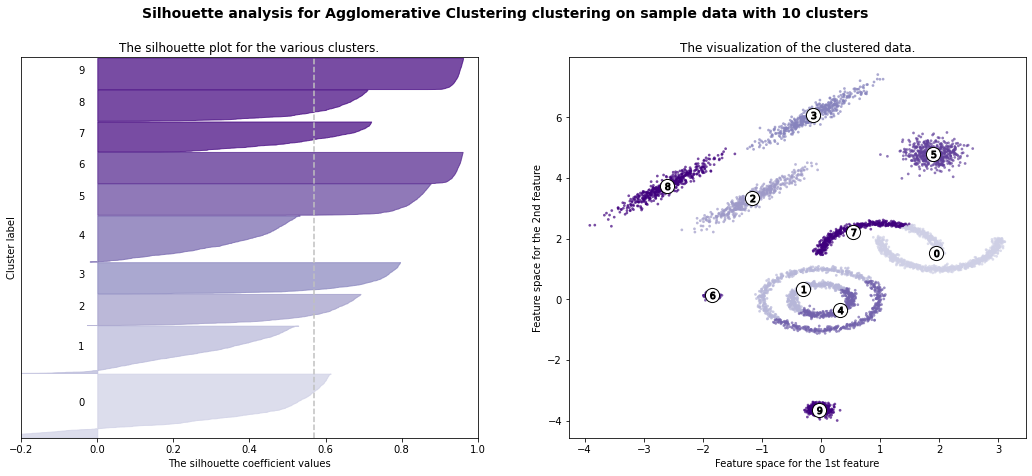

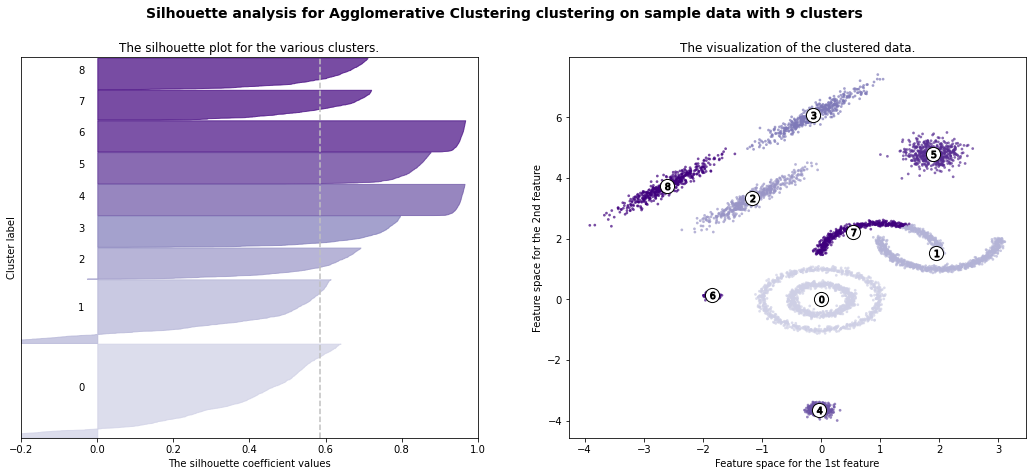

In [ ]:
silhouette_plot_method(range_clusters[1], algorithm[1], toy_data_set, alg[1])

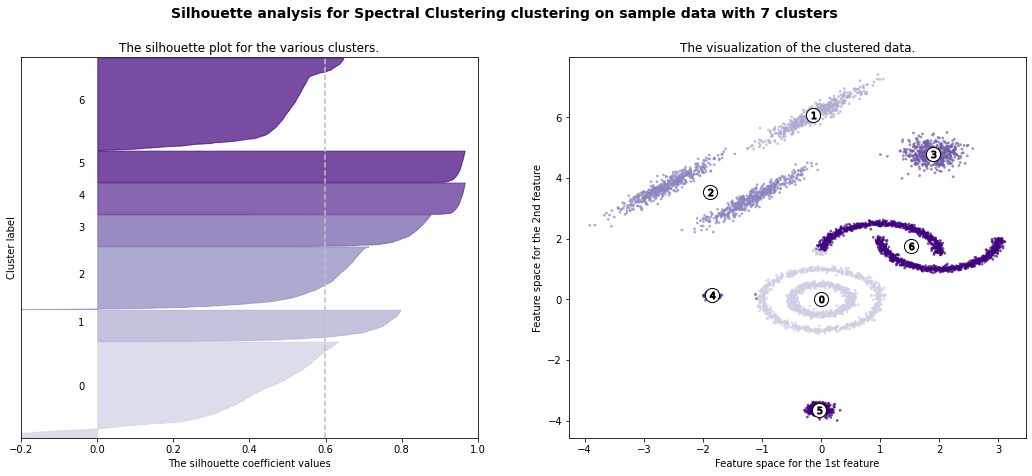

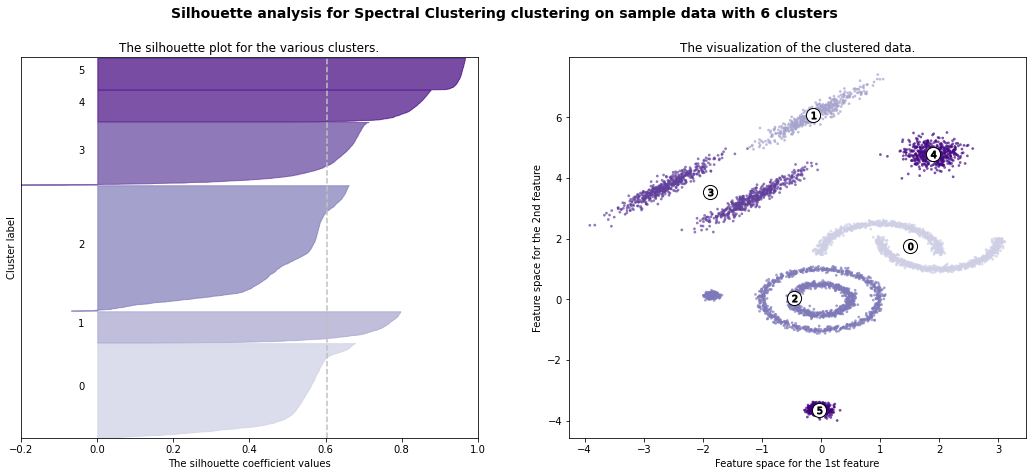

In [ ]:
silhouette_plot_method(range_clusters[2], algorithm[2], toy_data_set, alg[2])

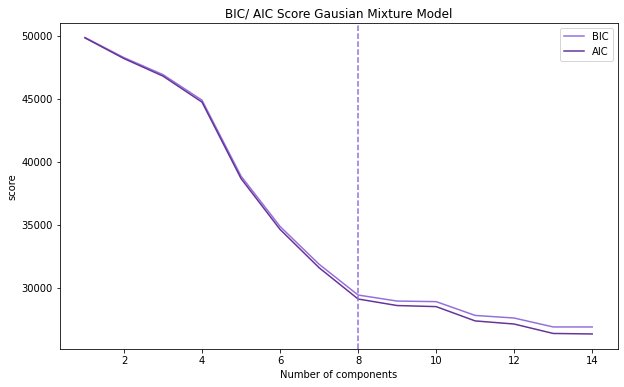

In [ ]:
n_components = np.arange(1, 15)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(toy_data_set) for n in n_components]
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(n_components, [m.bic(toy_data_set) for m in models], label='BIC', color = 'mediumpurple')
plt.plot(n_components, [m.aic(toy_data_set) for m in models], label='AIC', color = 'rebeccapurple')
plt.axvline(x = 8, color = 'mediumpurple', linestyle  ='--')
plt.legend(loc='best')
ax.set(title = 'BIC/ AIC Score Gausian Mixture Model' , ylabel = 'score', xlabel='Number of components');

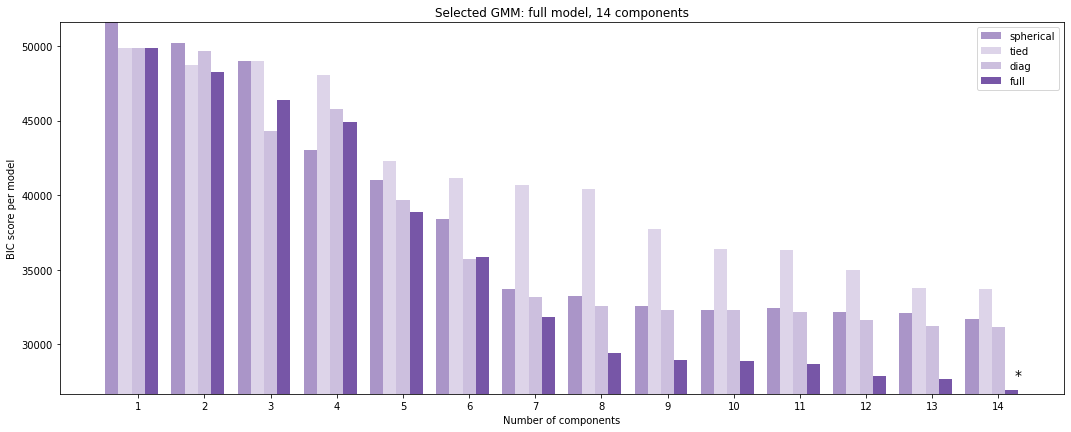

In [ ]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 15)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components = n_components, covariance_type = cv_type).fit(toy_data_set)
        bic.append(gmm.bic(toy_data_set))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['#aa95c8', '#ddd4e9', '#ccbfde', '#7756a7'])
clf = best_gmm
bars = []
plt.figure(figsize=(18, 6))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range): (i + 1) * len(n_components_range)], width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.ylabel('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)
plt.title(f'Selected GMM: {best_gmm.covariance_type} model, 'f'{best_gmm.n_components} components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [ ]:
def SelBest(arr:list, X:int)->list:
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [ ]:
def silhouette_score_GMM_method(data, end_range, max_iter):
  sils = []
  sils_error = []
  for n in np.arange(2, end_range):
      tmp_sil=[]
      for _ in range(max_iter):
          model = mixture.GaussianMixture(n, n_init=2).fit(data) 
          tmp_sil.append(sklearn.metrics.silhouette_score(data, model.predict(data), metric = 'euclidean'))
      val = np.mean(SelBest(np.array(tmp_sil), int(max_iter/5)))
      err = np.std(tmp_sil)
      sils.append(val)
      sils_error.append(err)
  return sils, sils_error

In [ ]:
sils, sils_err = silhouette_score_GMM_method(toy_data_set, end_range = 15, max_iter = 20)

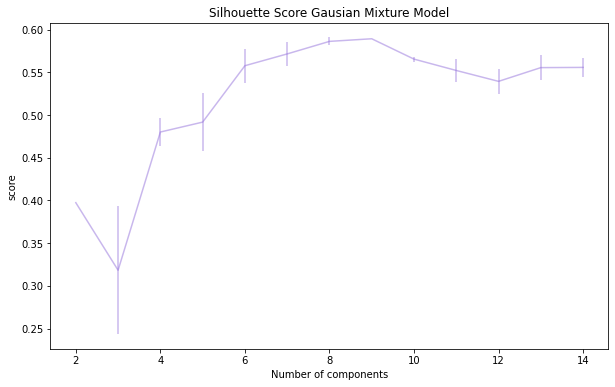

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.errorbar(np.arange(2, 15), sils, yerr=sils_err, color = 'mediumpurple', alpha = 0.5)
ax.set(title = 'Silhouette Score Gausian Mixture Model' , ylabel = 'score', xlabel='Number of components');

## K-means

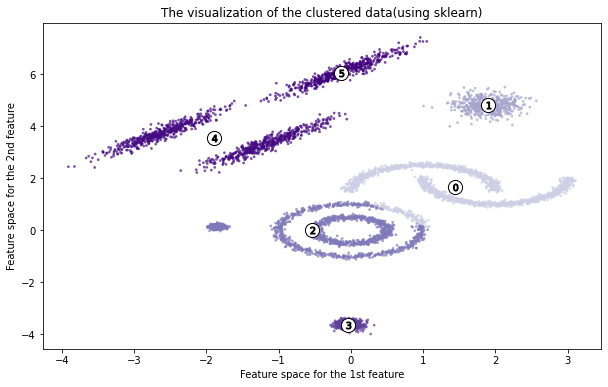

In [16]:
kmeans = sklearn.cluster.KMeans(n_clusters = 6).fit(toy_data_set)
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(kmeans.labels_.astype(float) /  np.unique(kmeans.labels_).shape[0] + 0.3 )
ax.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors, edgecolor = 'k')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker = 'o', c="white", alpha=1, s=200, edgecolor = 'k')
for i, c in enumerate(kmeans.cluster_centers_): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s=50, edgecolor = 'k')
ax.set_title("The visualization of the clustered data(using sklearn)")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

In [17]:
# saving metric results 

sep_ind.append(seperation_index(toy_data_set, kmeans.labels_))
fda_ind.append(fisher_index(toy_data_set, kmeans.labels_))

print(sep_ind)
print(fda_ind)

[0.01390545029135358]
[338114.9460564401]


## Affinity Propagation

/home/sahand/.local/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


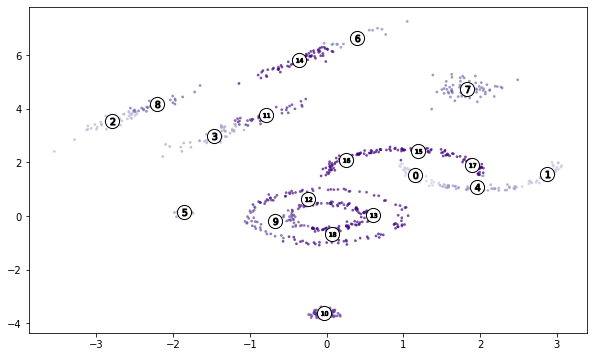

In [18]:
np.random.shuffle(toy_data_set)
sample_toy_data_set = toy_data_set[0:1000,:]
affinitypropagation = sklearn.cluster.AffinityPropagation(damping = 0.8).fit(sample_toy_data_set)
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(affinitypropagation.labels_.astype(float) /  np.unique(affinitypropagation.labels_).shape[0] + 0.3 )
ax.scatter(sample_toy_data_set[:, 0], sample_toy_data_set[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors, edgecolor = 'k')
centers = [np.mean(sample_toy_data_set[affinitypropagation.labels_ == i], axis = 0) for i in range(np.unique(affinitypropagation.labels_).shape[0])]
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha = 1, s = 200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s =50, edgecolor='k')
plt.show()

In [19]:
np.unique(affinitypropagation.labels_).shape[0]

19

In [20]:
# saving metric results 

sep_ind.append(seperation_index(toy_data_set, affinitypropagation.labels_))
fda_ind.append(seperation_index(toy_data_set, affinitypropagation.labels_))

print(sep_ind)
print(fda_ind)

[0.01390545029135358, 0.04043460306146617]
[338114.9460564401, 0.04043460306146617]



## Mean shift

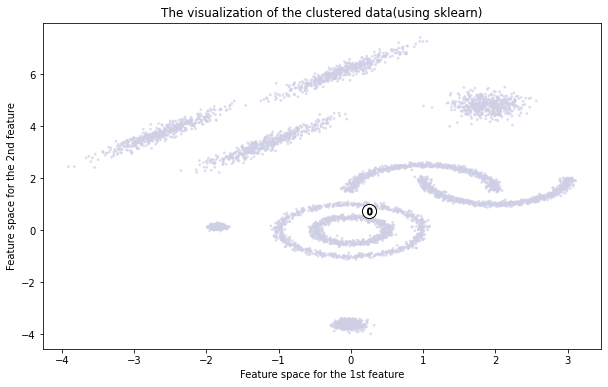

In [21]:
bandwidth = sklearn.cluster.estimate_bandwidth(toy_data_set)
meanshift = sklearn.cluster.MeanShift(bandwidth = bandwidth, min_bin_freq = 3, max_iter = 500).fit(toy_data_set)
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(meanshift.labels_.astype(float) /  np.unique(meanshift.labels_).shape[0] + 0.3)
ax.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors, edgecolor = 'k')
ax.scatter(meanshift.cluster_centers_[:, 0], meanshift.cluster_centers_[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(meanshift.cluster_centers_): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s=50, edgecolor='k')
ax.set_title("The visualization of the clustered data(using sklearn)")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

In [24]:
# saving metric results 

sep_ind.append(seperation_index(toy_data_set, meanshift.labels_))
fda_ind.append(fisher_index(toy_data_set, meanshift.labels_))


#print(sep_ind)
#print(fda_ind)

[0.01390545029135358, 0.04043460306146617, 0]
[338114.9460564401, 0.04043460306146617, 0]


## OPTICS

/home/sahand/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sahand/.local/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


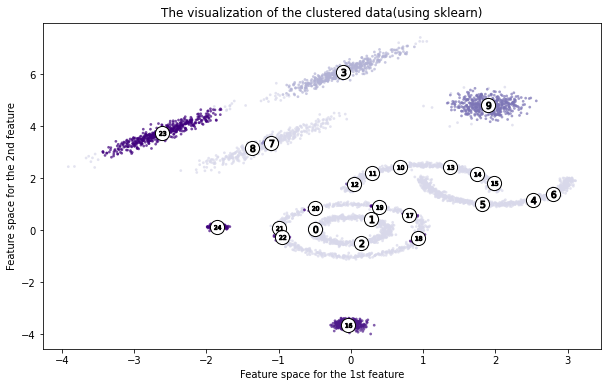

In [70]:
epsilon = 2.0
min_samples = 22

optcs = sklearn.cluster.OPTICS(max_eps = 0.2, min_samples = min_samples, cluster_method = 'xi', metric = 'minkowski').fit(toy_data_set)
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(optcs.labels_.astype(float) /  np.unique(optcs.labels_).shape[0] + 0.3)
ax.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors, edgecolor = 'k')
centers = [np.mean(toy_data_set[optcs.labels_ == i], axis = 0) for i in range(np.unique(optcs.labels_).shape[0])]
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha = 1, s = 200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s =50, edgecolor='k')
ax.set_title("The visualization of the clustered data(using sklearn)")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

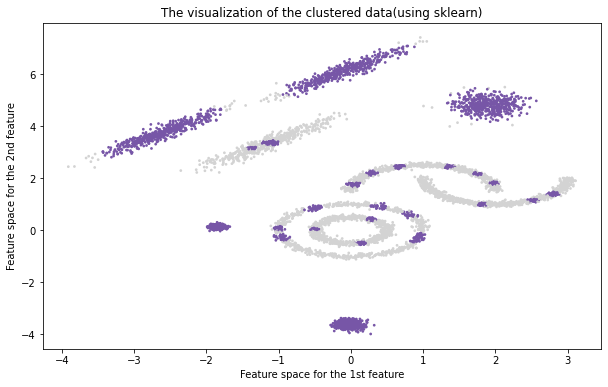

In [71]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = list(map(lambda x: 'lightgrey' if x == -1 else '#7756a7', optcs.labels_))
ax.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker = '.', s = 30, lw = 0, c = colors, edgecolor = 'k')
ax.set_title("The visualization of the clustered data(using sklearn)")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

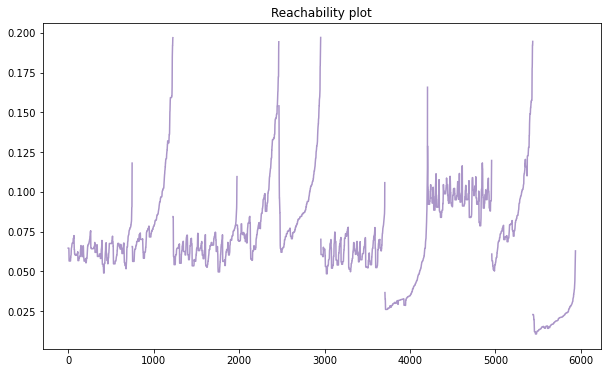

Estimated no. of clusters: 26
Estimated no. of noise points: 2889


In [72]:
reachability = optcs.reachability_[optcs.ordering_]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(reachability, color = '#aa95c8')

plt.title('Reachability plot')
plt.show()

print('Estimated no. of clusters: %d' % len(np.unique(optcs.labels_) ))
print('Estimated no. of noise points: %d' % np.sum(np.array(optcs.labels_) == -1, axis=0))

In [26]:
# saving metric results 
#print(np.unique( optcs.labels_))

#sep_ind.append(seperation_index(norm_bboxes, optcs.labels_))
# ERROR‌OCCURS‌FOR‌CALCULATING‌INTRA_CLUSTER‌DISTANCE‌IN‌THIS‌ALGORITHM

#fda_ind.append(fisher_index(norm_bboxes, optcs.labels_))
# ERROR‌OCCURS‌FOR‌CALCULATING‌INTRA‌CLUSTER‌VARIANCE‌MATRIX


sep_ind.append(0)
fda_ind.append(0)


print(sep_ind)
print(fda_ind)

[0.01390545029135358, 0.04043460306146617, 0, 0]
[338114.9460564401, 0.04043460306146617, 0, 0]


## Agglomerative Clustering

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy:
* Single linkage minimizes the distance between the closest observations of pairs of clusters.

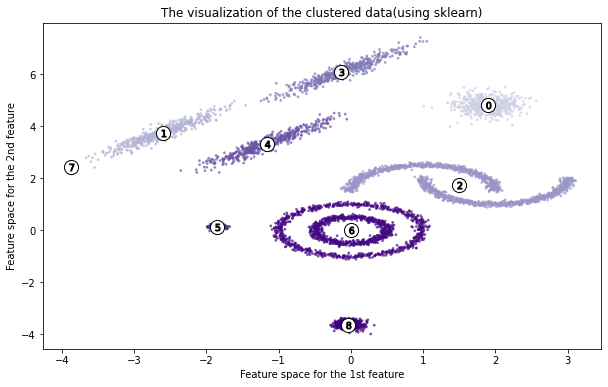

In [27]:
agglomerative = sklearn.cluster.AgglomerativeClustering(n_clusters = 9, linkage = 'single').fit(toy_data_set)
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(agglomerative.labels_.astype(float) /  np.unique(agglomerative.labels_).shape[0] + 0.3  )
ax.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors, edgecolor = 'k')
centers = [np.mean(toy_data_set[agglomerative.labels_ == i], axis = 0) for i in range(np.unique(agglomerative.labels_).shape[0])]
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha = 1, s = 200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s =50, edgecolor='k')
ax.set_title("The visualization of the clustered data(using sklearn)")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

In [40]:
# saving metric results 


sep_ind.append(seperation_index(toy_data_set, agglomerative.labels_))
fda_ind.append(fisher_index(toy_data_set, agglomerative.labels_))

print(sep_ind)
print(fda_ind)

[0.01390545029135358, 0.04043460306146617, 0, 0, 0.6861356474050319]
[338114.9460564401, 611487.6663854735, 0, 0, 430347.56074910925]


## DBSCAN

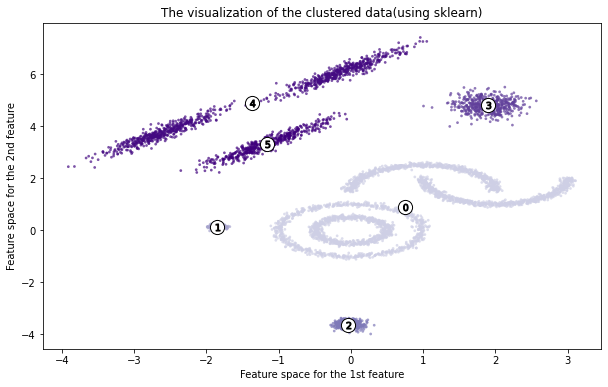

In [ ]:
dbscan = sklearn.cluster.DBSCAN().fit(toy_data_set)
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(dbscan.labels_.astype(float) / np.unique(dbscan.labels_).shape[0] + 0.3 )
ax.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors)
centers = [np.mean(toy_data_set[dbscan.labels_ == i], axis = 0) for i in range(np.unique(dbscan.labels_).shape[0])]
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha = 1, s = 200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s =50, edgecolor='k')
ax.set_title("The visualization of the clustered data(using sklearn)")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

In [42]:
from time import sleep
import sys
def tune_DBSCAN( range_points , range_radius , data ):
    silhouette_avg = np.zeros(( len( range_points ) , len( range_radius ) ))
    counter = np.arange(1,21)
    for i in range( len( range_radius ) ):
        for j in range( len( range_points ) ):
            dbscan = sklearn.cluster.DBSCAN(eps=range_radius[ i ],min_samples = range_points[ j ]).fit(data)
            #print("Itteration " + str( j+i*len( range_points ) ) + " is Done!"  )
            sys.stdout.flush()
            sys.stdout.write('\r')
            # the exact output you're looking for:
            sys.stdout.write("[%-20s] %.4f%%" % ('='*counter[i], 5*counter[i]))
            if len( np.unique( dbscan.labels_ ) ) > 1:
                silhouette_avg[ j , i ] = np.exp( sklearn.metrics.silhouette_score( data , dbscan.labels_ ) )
    max = np.unravel_index( np.argmax( silhouette_avg ) , silhouette_avg.shape )
    max_score = ( range_points[ max[ 0 ] ] , range_radius[ max[ 1 ] ] )
    return silhouette_avg , max_score

In [43]:
radius = 0.002*(np.arange(1,21))
min_points = np.arange( 2 , 22 )
silhouette_avg , max_score = tune_DBSCAN( min_points , radius , toy_data_set )
df = pd.DataFrame( max_score )
df.to_csv('Toy_SK_DBSCAN_maxscore.csv')
!cp Toy_SK_DBSCAN_maxscore.csv "drive/My Drive/IS/Final/"
df = pd.DataFrame( silhouette_avg )
df.to_csv('Toy_SK_DBSCAN_silhouette_avg.csv')
!cp Toy_SK_DBSCAN_silhouette_avg.csv "drive/My Drive/IS/Final/"

NameError: name 'toy_data' is not defined

In [ ]:
Toy_SK_DBSCAN_maxscore = pd.read_csv('/content/drive/My Drive/IS/Final/Toy_SK_DBSCAN_maxscore.csv').to_numpy()
Toy_SK_DBSCAN_silhouette_avg = pd.read_csv('/content/drive/My Drive/IS/Final/Toy_SK_DBSCAN_silhouette_avg.csv').to_numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'ydir'
  


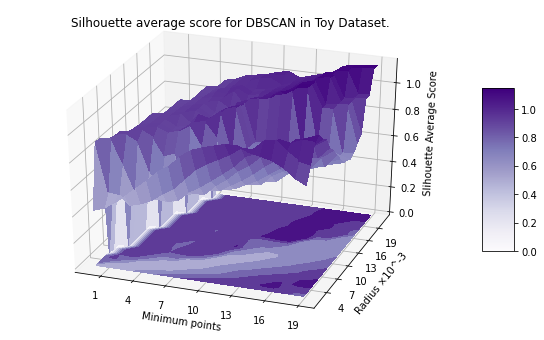

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
# Make data.
X, Y = np.meshgrid(range(len(np.arange(1,21))), np.arange( 2 , 22 ))
Z = Toy_SK_DBSCAN_silhouette_avg[:,1:]
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap='Purples', linewidth=0, antialiased=False)
cset = ax.contourf(X, Y, Z, ydir='y',offset=0, cmap='Purples')
ax.set_title("Silhouette average score for DBSCAN in Toy Dataset.")
ax.set_xlabel("Minimum points")
ax.set_ylabel("Radius ×10^-3")
ax.set_zlabel("Slihouette Average Score")
ax.set_xticks(np.arange(1,21 ,3))
ax.set_yticks(np.arange(1 , 21 , 3))
#cset = ax.contourf(X, Y, Z, zdir='x',offset=-0.1, cmap='PuBu')
ax.view_init(  elev = 30,azim=-70 )
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5 )
plt.show()

/home/sahand/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sahand/.local/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


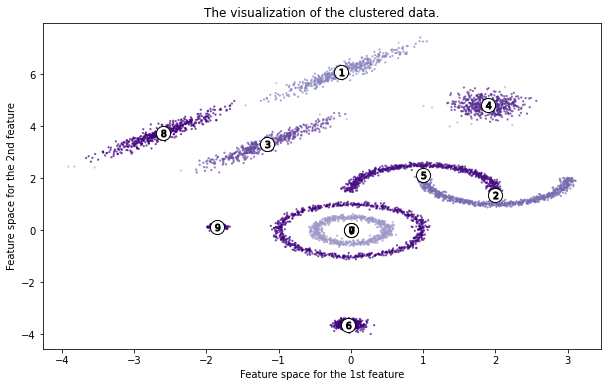

In [45]:
dbscan = sklearn.cluster.DBSCAN(eps=0.15,min_samples = 4).fit(toy_data_set)
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(dbscan.labels_.astype(float) / np.unique(dbscan.labels_).shape[0] + 0.5 )
plt.scatter(toy_data_set[:,0], toy_data_set[:,1],s = 5, lw = 0, c = colors , alpha = 0.7)
centers = [np.mean(toy_data_set[dbscan.labels_ == i], axis = 0) for i in range(np.unique(dbscan.labels_).shape[0])]
for i in range(np.unique(dbscan.labels_).shape[0]):
    if dbscan.labels_[ i ] == 6:
        centers[ 6 ] = np.array(toy_data_set[i])
        break
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha = 1, s = 200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s =50, edgecolor='k')
ax.set_title("The visualization of the clustered data.")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

In [47]:
# saving metric results 

sep_ind.append(0)
fda_ind.append(0)


#sep_ind.append(seperation_index(toy_data_set, dbscan.labels_))
#fda_ind.append(fisher_index(toy_data_set, dbscan.labels_))

print(sep_ind)
print(fda_ind)

[0.01390545029135358, 0.04043460306146617, 0, 0, 0.6861356474050319, 0]
[338114.9460564401, 611487.6663854735, 0, 0, 430347.56074910925, 0]


## Gaussian Mixture Model

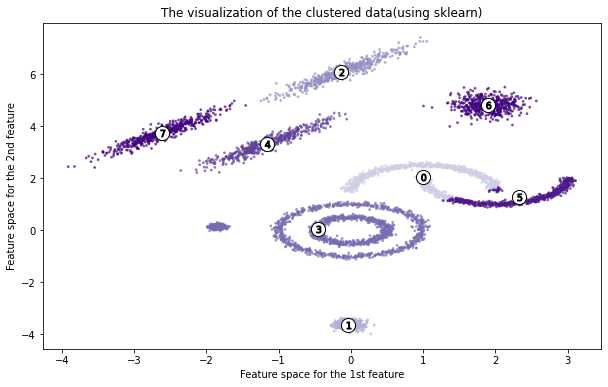

In [49]:
gmm = mixture.GaussianMixture(n_components = 8, random_state = 0).fit(toy_data_set)
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(gmm.predict(toy_data_set).astype(float) / np.unique(gmm.predict(toy_data_set)).shape[0] + 0.3 )
ax.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors)
centers = [np.mean(toy_data_set[gmm.predict(toy_data_set) == i], axis = 0) for i in range(np.unique(gmm.predict(toy_data_set)).shape[0])]
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s=50, edgecolor='k')
ax.set_title("The visualization of the clustered data(using sklearn)")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

In [51]:
# saving metric results 

sep_ind.append(seperation_index(toy_data_set, gmm.predict(toy_data_set)))
fda_ind.append(fisher_index(toy_data_set,  gmm.predict(toy_data_set)))

print(sep_ind)
print(fda_ind)

[0.01390545029135358, 0.04043460306146617, 0, 0, 0.6861356474050319, 0, 0.08059743231200321]
[338114.9460564401, 611487.6663854735, 0, 0, 430347.56074910925, 0, 347834.68051685276]


## Spectral Clustering

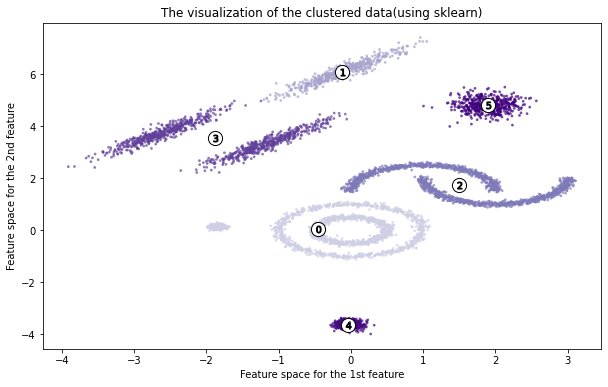

In [52]:
sc = sklearn.cluster.SpectralClustering(n_clusters = 6).fit(toy_data_set)
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(sc.labels_.astype(float) / np.unique(sc.labels_).shape[0] + 0.3 )
ax.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors)
centers = [np.mean(toy_data_set[sc.labels_ == i], axis = 0) for i in range(np.unique(sc.labels_).shape[0])]
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s=50, edgecolor='k')
ax.set_title("The visualization of the clustered data(using sklearn)")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

In [53]:
# saving metric results 

sep_ind.append(seperation_index(toy_data_set, sc.labels_))
fda_ind.append(fisher_index(toy_data_set,  sc.labels_))

print(sep_ind)
print(fda_ind)

[0.01390545029135358, 0.04043460306146617, 0, 0, 0.6861356474050319, 0, 0.08059743231200321, 0.2599294557167713]
[338114.9460564401, 611487.6663854735, 0, 0, 430347.56074910925, 0, 347834.68051685276, 337639.3083803991]


# Comparison and Evaluation

In [102]:
algorithms= ['k-means', 'AffinityPropagation', 'MeanShift', 'OPTICS', 'Agglomerative', 'DBSCAN', 'GMM', 'Spectral']

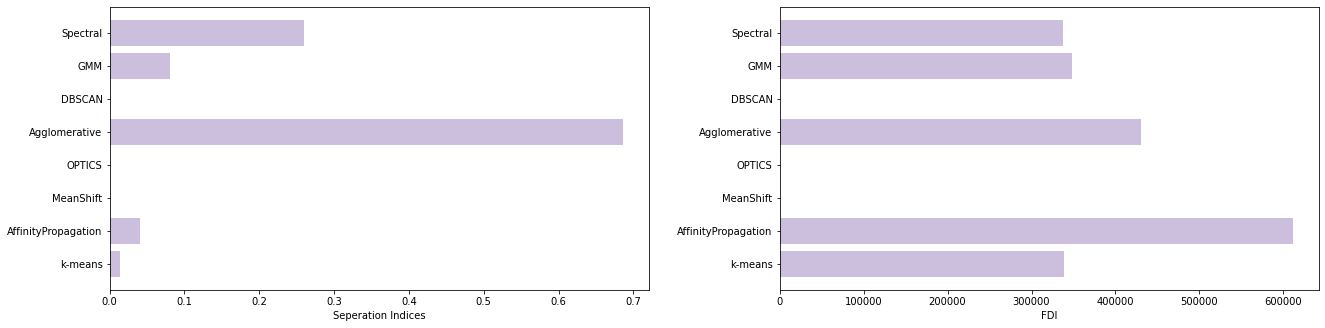

In [59]:
barchart_comparison(algorithms, sep_ind, fda_ind, clr = '#ccbfde')

 #### Metrics failed to provide output for DBSCAN and OPTICS due to their internal outlier detection that assigns the label '-1' to noise
 
 Meanshift divided data into only 1 cluster that metrics fail to evaluate them in the current definition
 
 #### Solution: set aside noisy data and then give algorithms cleaned output to metric indicator functions

In [84]:
print(np.shape(np.where(optcs.labels_ == -1))[1])
toy_data_set_nl = toy_data_set[np.where(optcs.labels_ != -1)]
optcs_labels_nl = optcs.labels_[np.where(optcs.labels_ != -1)]

2889


In [94]:
print(np.shape(np.where(dbscan.labels_ == -1))[1])
toy_data_set_nl = toy_data_set[np.where(dbscan.labels_ != -1)]
dbscan_labels_nl = dbscan.labels_[np.where(dbscan.labels_ != -1)]

16


 As we see Optics labels 2889 datapoints as noise and DBSCAN labels 16 datapoints as noise!

Recaluculating Metrics for OPTICS

In [97]:
# saving metric results 

sep_ind[3] = seperation_index(toy_data_set_nl, optcs_labels_nl)
fda_ind[3] = fisher_index(toy_data_set_nl,  optcs_labels_nl)

print(sep_ind)
print(fda_ind)

[0.01390545029135358, 0.04043460306146617, 0, 8.107543840010584e-05, 0.6861356474050319, 14757.020534241721, 0.08059743231200321, 0.2599294557167713]
[338114.9460564401, 611487.6663854735, 0, 14757.020534241721, 430347.56074910925, 0, 347834.68051685276, 337639.3083803991]


In [98]:
# saving metric results 

sep_ind[5] = seperation_index(toy_data_set_nl, dbscan_labels_nl)
fda_ind[5] = fisher_index(toy_data_set_nl,  dbscan_labels_nl)

print(sep_ind)
print(fda_ind)

[0.01390545029135358, 0.04043460306146617, 0, 8.107543840010584e-05, 0.6861356474050319, 0.17265366746409838, 0.08059743231200321, 0.2599294557167713]
[338114.9460564401, 611487.6663854735, 0, 14757.020534241721, 430347.56074910925, 415291.2143845306, 347834.68051685276, 337639.3083803991]


### After Denoising data, the problem was solved for OPTICS and DBSCAN

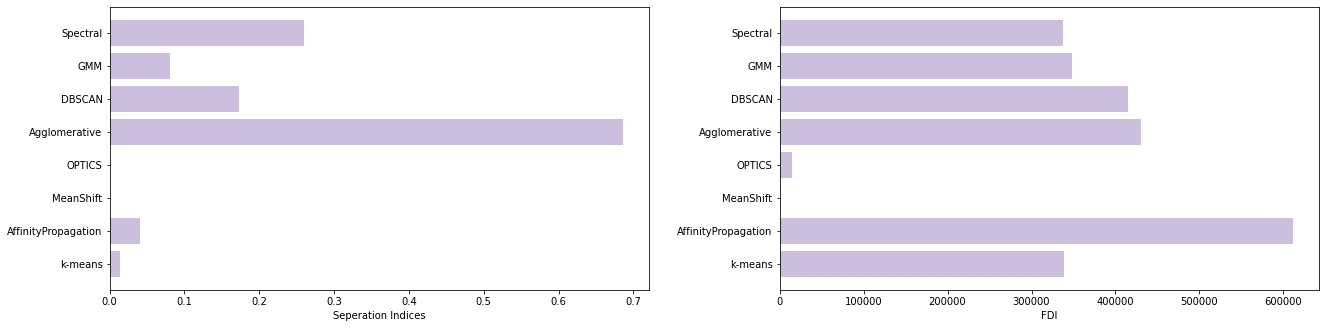

In [113]:
barchart_comparison(algorithms, sep_ind, fda_ind, clr = '#ccbfde')

#### As OPTICS Performs very poor on the dataset it has a negligable separation index value

### Solving the problem for Mean Shift using bandwidth modification

In [114]:
bandwidth

2.6071598788904993

### By decreasing the bw from the estimated value(2.61)  to 1.5, 5 clusters are created

In [115]:
bandwidth = 1.5

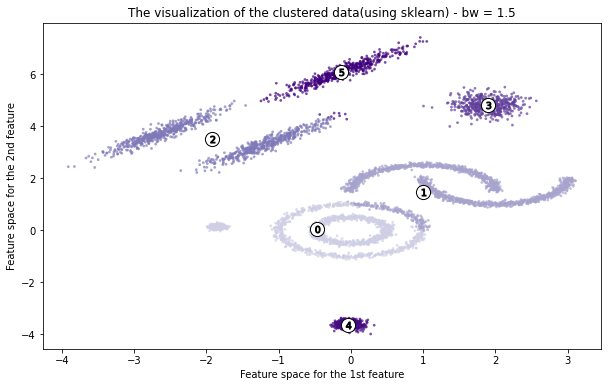

In [117]:
meanshift = sklearn.cluster.MeanShift(bandwidth = bandwidth, min_bin_freq = 3, max_iter = 500).fit(toy_data_set)
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(meanshift.labels_.astype(float) /  np.unique(meanshift.labels_).shape[0] + 0.3)
ax.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors, edgecolor = 'k')
ax.scatter(meanshift.cluster_centers_[:, 0], meanshift.cluster_centers_[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(meanshift.cluster_centers_): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s=50, edgecolor='k')
ax.set_title("The visualization of the clustered data(using sklearn) - bw = 1.5")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

In [119]:
sep_ind[2] = seperation_index(toy_data_set, meanshift.labels_)
fda_ind[2] = fisher_index(toy_data_set,  meanshift.labels_)

print(sep_ind)
print(fda_ind)

[0.01390545029135358, 0.04043460306146617, 0.01390545029135358, 8.107543840010584e-05, 0.6861356474050319, 0.17265366746409838, 0.08059743231200321, 0.2599294557167713]
[338114.9460564401, 611487.6663854735, 338995.1478199736, 14757.020534241721, 430347.56074910925, 415291.2143845306, 347834.68051685276, 337639.3083803991]


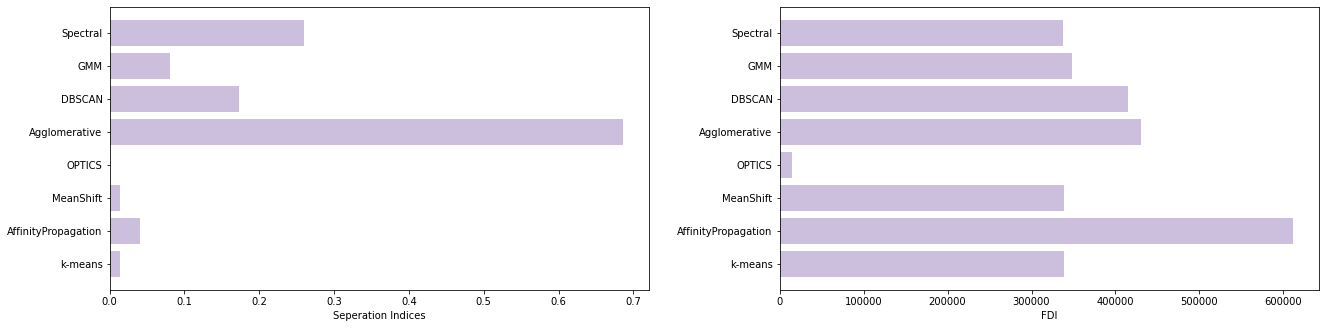

In [120]:
barchart_comparison(algorithms, sep_ind, fda_ind, clr = '#ccbfde')